In [ ]:
# Importing necessary libraries
import copy
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import hstack
from sklearn.preprocessing import StandardScaler
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
import errno

from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter
import imblearn
import collections
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

In [ ]:
# Function to load and categorise the data
import pandas as pd

def load_data_south_indian(url):

    df = pd.read_csv(url)

    df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 89 else
        4 if 90 <= x <= 115 else
        5
    )
    return df

def load_data_south_pacific(url):

   df = pd.read_csv(url)
   df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 85 else
        4 if 86 <= x <= 107 else
        5
    )
   return df


In [ ]:
ocean = 'south_pacific'

# Display the selected ocean
print(f"Selected ocean: {ocean}")

# Set the data URL and function based on the selected ocean
if ocean == 'south_indian':
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_indian_hurricane.csv'
    data_loading_function = load_data_south_indian
    hot_encoded_result_file_name = 'south_indian'
    category_result_file_name = 'roc_data_south_indian'
else:
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv'
    data_loading_function = load_data_south_pacific
    hot_encoded_result_file_name = 'south_pacific'
    category_result_file_name = 'roc_data_south_pacific'

# Display the data URL
print(f"Data URL: {url_data}")

# Display the result file names
print(f"Hot-encoded result file name: {hot_encoded_result_file_name}")
print(f"Category result file name: {category_result_file_name}")


Selected ocean: south_pacific
Data URL: https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv
Hot-encoded result file name: south_pacific
Category result file name: roc_data_south_pacific


In [ ]:
# Load data using the specified function and URL
df = data_loading_function(url_data)

# Latitude and longitude values into int
df['Lat'] = df['Lat'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('N') else int(x[:-1]) * 0.1 if x.endswith('S') else 0)
df['Lon'] = df['Lon'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('W') else int(x[:-1]) * 0.1 if x.endswith('E') else 0)

# Extract 'Speed(knots)' and 'category' columns as lists
speed = df['Speed(knots)'].tolist()
categories = df['category'].tolist()
latitude = df['Lat'].tolist()
longitude = df['Lon'].tolist()

# Display the first few rows of the DataFrame
df_head = df.head()
print("DataFrame Head:")
print(df_head)

DataFrame Head:
  Basin  No. of Cycl        Time     V5  V6   Lat    Lon  Speed(knots)  \
0    SP           14  1982012518   BEST   0  18.0  154.1            25   
1    SP           14  1982012600   BEST   0  19.1  154.8            25   
2    SP           14  1982012606   BEST   0  19.7  155.7            25   
3    SP           14  1982012612   BEST   0  19.9  156.7            30   
4    SP           14  1982012618   BEST   0  20.1  157.8            35   

   lat_tenth  lon_tenth  category  
0       18.0      154.1         0  
1       19.1      154.8         0  
2       19.7      155.7         0  
3       19.9      156.7         0  
4       20.1      157.8         1  


In [ ]:
# Functions to split cyclone sequences
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def multivariate_split_sequence(sequence, n_steps):

    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

features_columns = ['Lat', 'Lon','Speed(knots)']
target_column = 'category'

# Extract features and target
features = df[features_columns].values
target = df[target_column].values

n_steps = 5  # Number of input time steps

X, y = multivariate_split_sequence(features, n_steps)

# Now X contains sequences of 'Latitude', 'Longitude', and 'Speed(knots)' for each time step,
# and y contains the corresponding 'category' values.

def rmse(pred, actual):

    return np.sqrt(((pred - actual) ** 2).mean())

def categorical(pred, actual):

    cm = confusion_matrix(pred, actual)
    acc = accuracy_score(actual, pred, normalize=True, sample_weight=None)
    ps1 = precision_score(pred, actual, average='micro')
    rs1 = recall_score(pred, actual, average='micro')
    f11 = f1_score(pred, actual, average='micro')
    auc = roc_auc_score(actual, pred)
    return acc, auc, cm, ps1, rs1, f11
def make_confusion_matrix_chart(cf_matrix_test, cmap='Blues', annot_kws=None):

    # Set up the figure and axes
    plt.figure(figsize=(12, 6))

    # Customize the heatmap using seaborn
    sns.heatmap(cf_matrix_test, annot=True, cmap=cmap,
                yticklabels=['0', '1'], xticklabels=['0', '1'],
                fmt='g', annot_kws=annot_kws)

    # Customize axis labels and title
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title('Confusion Matrix - Test Data')

    return None

In [ ]:
# Define whether it's a univariate or multivariate case
univariate = False

# Define sequence and time step parameters
n_steps_in = 6
n_seq = 3
n_steps_out = 1

# Define the number of features for input and output
n_features_in = 3  # Latitude, Longitude, Speed
n_features_out = 2  # Considering one-hot encoding

# Define the number of hidden layers in the model
hidden_layers = 50

# Define training parameters
epochs = 100
No_exp = 1 # Number of experiments

# Display the configuration
print(f"Univariate: {univariate}")
print(f"Number of Input Time Steps: {n_steps_in}")
print(f"Number of Input Sequences: {n_seq}")
print(f"Number of Output Time Steps: {n_steps_out}")
print(f"Number of Input Features: {n_features_in}")
print(f"Number of Output Features: {n_features_out}")
print(f"Number of Hidden Layers: {hidden_layers}")
print(f"Epochs: {epochs}")
print(f"Number of Experiments: {No_exp}")



Univariate: False
Number of Input Time Steps: 6
Number of Input Sequences: 3
Number of Output Time Steps: 1
Number of Input Features: 3
Number of Output Features: 2
Number of Hidden Layers: 50
Epochs: 100
Number of Experiments: 1


In [ ]:

cyclone_id = df['No. of Cycl'][0]
X = []
Y = []
start_index = 0
end_index = 0

# Iterate through the DataFrame
for i in range(1, df.shape[0]):
    # Check if the cyclone ID is the same as the previous row
    if df['No. of Cycl'][i] == cyclone_id:
        end_index += 1
    else:
        # Split the sequence and append to X and Y
        x, y = multivariate_split_sequence(features[start_index:end_index + 1, :], n_steps_in)
        X.append(x)
        Y.append(y)

        # Update start and end indices for the new cyclone
        cyclone_id = df['No. of Cycl'][i]
        start_index = i
        end_index = i

    # Check if it's the last row of the DataFrame
    if i == df.shape[0] - 1:
        # Split the sequence and append to X and Y
        x, y = multivariate_split_sequence(features[start_index:end_index + 1, :], n_steps_in)
        X.append(x)
        Y.append(y)
print(Y[0])


[40. 40. 40. 40. 40. 40. 40. 40. 35. 35. 40. 40. 40. 40. 40. 35. 35. 40.
 45. 45. 50. 50. 55. 55. 50. 55. 60. 65. 65. 65. 60. 50. 45. 45. 40. 40.
 35. 35. 30. 30. 25.]


In [ ]:
# Print the initial lengths of X and Y
print("Initial Lengths - X:", len(X), "Y:", len(Y))

# Flattening X and Y
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]

# Print lengths of X and Y after flattening
print("Flattened Lengths - X:", len(X), "Y:", len(Y))

# Print some initial values from X and Y
print(X[0], Y[0])

# Print some initial values from the 'speed' column
print("Sample Values - Speed:", speed[:10])
X1 = X
Y1 = Y
X2 = X
Y2 = Y


Initial Lengths - X: 391 Y: 391
Flattened Lengths - X: 9697 Y: 9697
[[ 18.  154.1  25. ]
 [ 19.1 154.8  25. ]
 [ 19.7 155.7  25. ]
 [ 19.9 156.7  30. ]
 [ 20.1 157.8  35. ]
 [ 20.4 158.6  40. ]] 40.0
Sample Values - Speed: [25, 25, 25, 30, 35, 40, 40, 40, 40, 40]


In [ ]:
# Initialize 'intensify_y' with zeros
intensify_y = [0] * len(X)

# Add labels for rapid intensification
for i in range(len(X)):
    for j in range(len(X[0]) - 4, len(X[0])):
        if (Y[i] - X[i][j][2]) >= 30:
            intensify_y[i] = 1
            break

print(len(intensify_y))

Y = intensify_y




9697


In [ ]:
# Calculate the training limit as 75% of the total length of X
train_limit = int(len(X) * 0.75)
print("Training set size:", train_limit)


Training set size: 7272


In [ ]:

test_X_original = X[train_limit + 1:]
test_Y_original = Y[train_limit + 1:]

# Display the lengths of the datasets
print("Length of X:", len(X))
print("Length of Y:", len(Y))
print("Length of Test X (for evaluation):", len(test_X_original))
print("Length of Test Y (for evaluation):", len(test_Y_original))


Length of X: 9697
Length of Y: 9697
Length of Test X (for evaluation): 2424
Length of Test Y (for evaluation): 2424


In [ ]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

X = np.array(X)
scalers = {}
for i in range(X.shape[1]):
    scalers[i] = MinMaxScaler()
    X[:, i, :] = scalers[i].fit_transform(X[:, i, :])
print(X[0])

[[0.39892183 0.92805556 0.07142857]
 [0.40526316 0.93       0.07142857]
 [0.40458015 0.9325     0.07142857]
 [0.3955774  0.93527778 0.10714286]
 [0.38625592 0.93833333 0.14285714]
 [0.37813212 0.94055556 0.17857143]]


In [ ]:
# Splitting into train and test sets
speed_x = X
test_X = X[train_limit+1:]
test_X = np.asarray(test_X).astype(float)
test_Y = Y[train_limit+1:]
X = X[:train_limit]
X = np.asarray(X).astype(float)
Y = Y[:train_limit]
print(len(test_X), len(test_Y))
len(X), len(Y)


2424 2424


(7272, 7272)

In [ ]:
# Calculate the class distribution for training and test data
counter_train = Counter(Y)
counter_test = Counter(test_Y)

# Display the class distribution for training data
print("Class Distribution - Training Data:")
print(counter_train)

# Display the class distribution for test data
print("\nClass Distribution - Test Data:")
print(counter_test)

Class Distribution - Training Data:
Counter({0: 6897, 1: 375})

Class Distribution - Test Data:
Counter({0: 2396, 1: 28})


In [ ]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return loss

# **Multivariate LSTM**

In [ ]:
def multivariate_vanilla_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out):
    """
    Create a Multivariate LSTM model for sequence prediction.

    Parameters:
    - n_steps_in: Number of time steps in the input sequence.
    - n_steps_out: Number of time steps in the output sequence.
    - n_features_in: Number of input features.
    - n_features_out: Number of output features.

    Returns:
    - model: Compiled Multivariate LSTM model.
    """
    # Initialize a sequential model
    model = Sequential()

    # Add an LSTM layer with 50 units and ReLU activation
    model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features_in)))

    # Add a Dense layer with a single unit and sigmoid activation for binary classification
    model.add(Dense(2, activation='softmax'))
    # Compile the model using Adam optimizer and binary crossentropy loss
    model.compile(optimizer='adam', loss=focal_loss(alpha=0.75, gamma=2.0), metrics=['accuracy'])

    return model

In [ ]:

def lstm(model_name, method, univariate, x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    # Initialize arrays to store accuracy metrics
    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)


    if model_name == 'vanilla':
        model = multivariate_vanilla_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out)
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    # Display the model summary
    model.summary()

    # Initialize arrays to store predictions and classification reports
    y_predicttest_allruns = np.zeros([Num_Exp, x_test.shape[0], y_test.shape[1]])
    Best_f1 = 0  # Initialize the best F1 score

    # Extract the actual classes from one-hot encoded vectors for both test and train sets
    act_test = [y_test[i].argmax() for i in range(y_test.shape[0])]
    act_train = [y_train[i].argmax() for i in range(y_train.shape[0])]

    # Initialize dictionaries to store classification reports
    Best_report_train = dict()
    Best_report_test = dict()
    all_report_train = dict()
    all_report_test = dict()

    # Loop through experiment runs
    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")

        # Fit the model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=10, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)

        # Extract predicted classes from one-hot encoded vectors
        pred_test = [y_predicttest[i].argmax() for i in range(y_predicttest.shape[0])]
        pred_train = [y_predicttrain[i].argmax() for i in range(y_predicttrain.shape[0])]

        # Generate classification reports
        report_train = classification_report(act_train, pred_train, labels=[0, 1], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0, 1], output_dict=True)

        # Store classification reports in dictionaries
        all_report_train[run] = report_train
        all_report_test[run] = report_test

        # Calculate F1-score for the test set
        test_acc[run] = report_test['1']['f1-score']
        print("train acc: ", report_train['1']['f1-score'])
        print("test acc: ", test_acc[run])

        precision_minority = report_test['1']['precision']
        recall_minority = report_test['1']['recall']
        print("Precision (Minority Class):", precision_minority)
        print("Recall (Minority Class):", recall_minority)

        macro_avg_precision = report_test['macro avg']['precision']
        macro_avg_recall = report_test['macro avg']['recall']
        macro_avg_f1 = report_test['macro avg']['f1-score']

        weighted_avg_precision = report_test['weighted avg']['precision']
        weighted_avg_recall = report_test['weighted avg']['recall']
        weighted_avg_f1 = report_test['weighted avg']['f1-score']

        # Print or store Macro Avg and Weighted Avg values
        print("Macro Avg Precision:", macro_avg_precision)
        print("Macro Avg Recall:", macro_avg_recall)
        print("Macro Avg F1-Score:", macro_avg_f1)

        print("Weighted Avg Precision:", weighted_avg_precision)
        print("Weighted Avg Recall:", weighted_avg_recall)
        print("Weighted Avg F1-Score:", weighted_avg_f1)



        # Update the best F1 score and associated predictions and reports
        if test_acc[run] > Best_f1:
            Best_f1 = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_report_train, Best_report_test = report_train, report_test

    # Save the trained model
    model.save("model_" + ocean + "_" + model_name + "_" + method + '.h5')

    # Calculate standard deviations of train and test accuracies
    train_std = np.std(train_acc)
    test_std = np.std(test_acc)

    # Display experiment summary
    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    print("F1 scores for test data: ", test_acc)
    print("Mean: ", np.mean(test_acc), "Std Dev: ", test_std)

    # Return relevant information
    return train_acc, test_acc, train_std, test_std, Best_Predict_Test, y_predicttrain, y_predicttest, all_report_train, all_report_test




In [ ]:
# Create a random permutation of indices for shuffling
idx = np.random.permutation(len(X))

# Initialize lists to store shuffled data
x_shuffled = []
y_shuffled = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    x_shuffled.append(X[i])
    y_shuffled.append(Y[i])
x_a = np.array(x_shuffled)
print(x_a.shape)


# Convert the shuffled labels to one-hot encoded format for training data
Y_hot_encoded_train = np.asarray(to_categorical(y_shuffled))

# Convert the test labels to one-hot encoded format
Y_hot_encoded_test = np.asarray(to_categorical(test_Y))

# Print the shapes of the one-hot encoded training and test labels
print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)


(7272, 6, 3)
(7272, 2) (2424, 2)


In [ ]:
# Testing on all 4 different kinds of LSTMs
models = ['vanilla']


# Initialize dictionaries to store predictions, actual values, and metrics for training and testing
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()
test_acc_all = dict()
test_stddev = dict()
train_loss_all = dict()
test_loss_all = dict()

In [ ]:

for j in range(1):

  predictions_train_per_step = dict()
  actual_train_per_step = dict()
  predictions_test_per_step = dict()
  actual_test_per_step = dict()
  metrics_train_per_step = dict()
  metrics_test_per_step = dict()
  test_acc_per_step = dict()
  test_stddev_per_step = dict()
  n_steps_out = j + 1

  print('---------------------------------------------------------')
  print('Number of steps out:', n_steps_out)

  # Loop over different LSTM models
  for i in models:
    print("For " + i + ":")

    # Reshape data based on the LSTM model type
    if i == 'vanilla' or i == 'bidirectional' :
        x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
        x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))
    elif i == 'cnn-lstm':
        x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
        x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
        x_train = x_train.reshape((x_train.shape[0], n_seq, int(n_steps_in / n_seq), n_features_in))
        x_test = x_test.reshape((x_test.shape[0], n_seq, int(n_steps_in / n_seq), n_features_in))
    elif i == 'conv-lstm':
        print("Original shape of x_shuffled:", np.array(x_shuffled).shape)
        x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
        print("Shape after reshape:", np.array(x_train).shape)
        x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
        x_train = x_train.reshape((x_train.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
        x_test = x_test.reshape(x_test.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in)

    # Call the LSTM function and retrieve results
    train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = lstm(
        i, 'original', univariate, x_train, x_test, y_train, y_test, No_exp, n_steps_in, n_steps_out, epochs, hidden_layers)

    # Store results in respective dictionaries
    predictions_train_per_step[i] = y_predicttrain
    actual_train_per_step[i] = y_train
    predictions_test_per_step[i] = Best_Predict_Test
    actual_test_per_step[i] = y_test
    metrics_train_per_step[i] = report_train
    metrics_test_per_step[i] = report_test
    test_acc_per_step[i] = test_acc
    test_stddev_per_step[i] = test_std_dev

# Store results for the current n_steps_out in the overall dictionaries
  predictions_train[str(j + 1)] = predictions_train_per_step
  actual_train[str(j + 1)] = actual_train_per_step
  predictions_test[str(j + 1)] = predictions_test_per_step
  actual_test[str(j + 1)] = actual_test_per_step
  metrics_train[str(j + 1)] = metrics_train_per_step
  metrics_test[str(j + 1)] = metrics_test_per_step
  test_acc_all[str(j + 1)] = test_acc_per_step
  test_stddev[str(j + 1)] = test_stddev_per_step


---------------------------------------------------------
Number of steps out: 1
For vanilla:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,902 (42.59 KB)

 Trainable params: 10,902 (42.59 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1 in progress
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


train acc:  0.8022440392706872
test acc:  0.49230769230769234
Precision (Minority Class): 0.43243243243243246
Recall (Minority Class): 0.5714285714285714
Macro Avg Precision: 0.713702600799375
Macro Avg Recall: 0.7813319818745528
Macro Avg F1-Score: 0.7427041284034803
Weighted Avg Precision: 0.9884747784779724
Weighted Avg Recall: 0.9863861386138614
Weighted Avg F1-Score: 0.9873158283518406
Total time for 1 experiments 237.63129210472107
F1 scores for test data:  [0.49230769]
Mean:  0.49230769230769234 Std Dev:  0.0


# **Code to run the Multivariate LSTM**

In [ ]:
with open("predictions_" + ocean + '_original' + '.pkl', 'wb') as f:
    pickle.dump([predictions_train,actual_train,predictions_test,actual_test,metrics_train,metrics_test,test_acc,test_stddev], f)


In [ ]:
# Function to make confusion matrix
def make_confusion_matrix_chart(cf_matrix, name):

    # Set a Seaborn style with dark grid
    sns.set(style="darkgrid", font_scale=1.5)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Customize the appearance of the heatmap with green colors
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Greens',
                linewidths=.5, square=True, cbar=False,
                annot_kws={"size": 16}, ax=ax)

    # Set labels and title
    plt.ylabel("Actual", size=18)
    plt.xlabel("Predicted", size=18)
    plt.title("Confusion Matrix", size=20)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Save the plot as an image
    plt.savefig(name + '.png', dpi=300, transparent=False, bbox_inches='tight')

    # Display the plot
    plt.show()

    return None




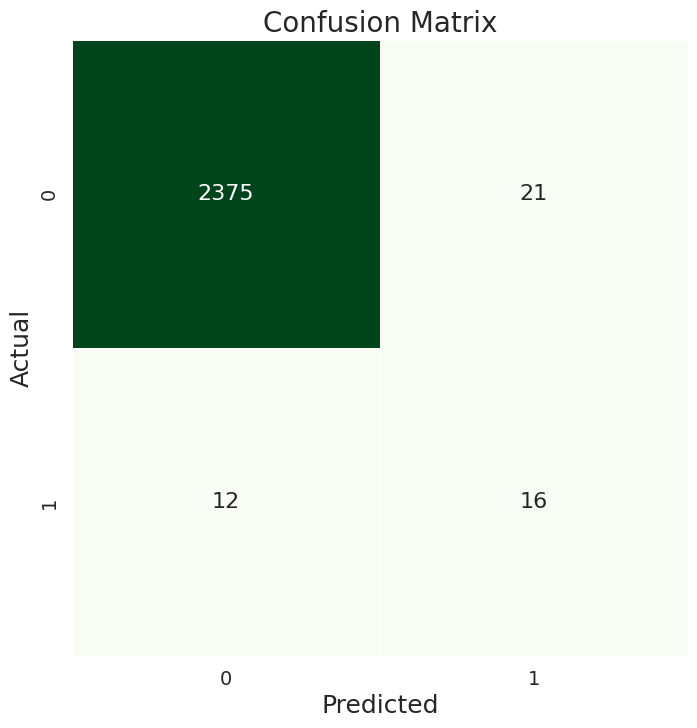

In [ ]:
# Code to display confucion matrix
y = [i.argmax() for i in actual_test_per_step['vanilla']]
pred = [i.argmax() for i in predictions_test_per_step['vanilla']]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart(cf_matrix_test, ocean + 'vanilla_cm_original')


In [ ]:
# Code to display results
# Initialize lists to store precision, recall, and F1-score metrics for class 0, class 1, overall accuracy,
# macro average, and weighted average across multiple experiments
precision0 = []
precision1 = []
precisionacc = []
precisionmacavg = []
precisionweighavg = []
recall0 = []
recall1 = []
recallacc = []
recallmacavg = []
recallweighavg = []
f10 = []
f11 = []
f1acc = []
f1macavg = []
f1weighavg = []


for i in range(No_exp):

    precision0.append(metrics_test_per_step['vanilla'][i]['0']['precision'])
    precision1.append(metrics_test_per_step['vanilla'][i]['1']['precision'])
    precisionacc.append(metrics_test_per_step['vanilla'][i]['accuracy'])
    precisionmacavg.append(metrics_test_per_step['vanilla'][i]['macro avg']['precision'])
    precisionweighavg.append(metrics_test_per_step['vanilla'][i]['weighted avg']['precision'])

    recall0.append(metrics_test_per_step['vanilla'][i]['0']['recall'])
    recall1.append(metrics_test_per_step['vanilla'][i]['1']['recall'])
    recallacc.append(metrics_test_per_step['vanilla'][i]['accuracy'])
    recallmacavg.append(metrics_test_per_step['vanilla'][i]['macro avg']['recall'])
    recallweighavg.append(metrics_test_per_step['vanilla'][i]['weighted avg']['recall'])

    f10.append(metrics_test_per_step['vanilla'][i]['0']['f1-score'])
    f11.append(metrics_test_per_step['vanilla'][i]['1']['f1-score'])
    f1acc.append(metrics_test_per_step['vanilla'][i]['accuracy'])
    f1macavg.append(metrics_test_per_step['vanilla'][i]['macro avg']['f1-score'])
    f1weighavg.append(metrics_test_per_step['vanilla'][i]['weighted avg']['f1-score'])


In [ ]:
print(str(round(np.mean(precision0),4)) + "±" + str(round(np.std(precision0),4))," & " + str(round(np.mean(recall0),4)) + "±" + str(round(np.std(recall0),4)), " & " + str(round(np.mean(f10),4)) + "±" + str(round(np.std(f10),4)))
print(str(round(np.mean(precision1),4)) + "±" + str(round(np.std(precision1),4))," & " + str(round(np.mean(recall1),4)) + "±" + str(round(np.std(recall1),4)), " & " + str(round(np.mean(f11),4)) + "±" + str(round(np.std(f11),4)))
print(str(round(np.mean(precisionacc),4)) + "±" + str(round(np.std(precisionacc),4))," & " + str(round(np.mean(recallacc),4)) + "±" + str(round(np.std(recallacc),4)), " & " + str(round(np.mean(f1acc),4)) + "±" + str(round(np.std(f1acc),4)))
print(str(round(np.mean(precisionmacavg),4)) + "±" + str(round(np.std(precisionmacavg),4))," & " + str(round(np.mean(recallmacavg),4)) + "±" + str(round(np.std(recallmacavg),4)), " & " + str(round(np.mean(f1macavg),4)) + "±" + str(round(np.std(f1macavg),4)))
print(str(round(np.mean(precisionweighavg),4)) + "±" + str(round(np.std(precisionweighavg),4))," & " + str(round(np.mean(recallweighavg),4)) + "±" + str(round(np.std(recallweighavg),4)), " & " + str(round(np.mean(f1weighavg),4)) + "±" + str(round(np.std(f1weighavg),4)))



0.995±0.0  & 0.9912±0.0  & 0.9931±0.0
0.4324±0.0  & 0.5714±0.0  & 0.4923±0.0
0.9864±0.0  & 0.9864±0.0  & 0.9864±0.0
0.7137±0.0  & 0.7813±0.0  & 0.7427±0.0
0.9885±0.0  & 0.9864±0.0  & 0.9873±0.0
